In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import pandas as pd 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from activephasemap.models.np import NeuralProcess
from activephasemap.models.mlp import MLP
from activephasemap.utils.simulators import UVVisExperiment
from activephasemap.utils.visuals import get_twod_grid
from activephasemap.utils.acquisition import CompositeModelUncertainity
import json 

from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps 
from matplotlib.cm import ScalarMappable

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

import pdb

In [2]:
DATA_DIR = "./output/"
with open('/Users/pozzolabadmin/Documents/codebase/experiments/peptide_phase_mapping/04012024/best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]
design_space_bounds = [(0.0, 87.0), (0.0,11.0)]

In [3]:
def load_models_from_iteration(iter):
    expt = UVVisExperiment(design_space_bounds, "../data/")
    expt.read_iter_data(iter)
    expt.generate(use_spline=True)

    # Load trained MLP model for p(z|c)
    train_x = torch.load(DATA_DIR+'/train_x_%d.pt'%iter, map_location=device)
    train_z_mean = torch.load(DATA_DIR+'/train_z_mean_%d.pt'%iter, map_location=device)
    train_z_std = torch.load(DATA_DIR+'/train_z_std_%d.pt'%iter, map_location=device)
    mlp = MLP(train_x, train_z_mean, train_z_std)
    mlp_state_dict = torch.load(DATA_DIR+'/comp_model_%d.pt'%(iter), map_location=device)
    mlp.load_state_dict(mlp_state_dict)

    # Load trained NP model for p(y|z)
    NP = NeuralProcess(best_np_config["r_dim"], N_LATENT, best_np_config["h_dim"]).to(device)
    NP.load_state_dict(torch.load(DATA_DIR+'/np_model_%d.pt'%(iter), map_location=device))

    return expt, mlp, NP

In [4]:
def from_comp_to_spectrum(t, c, comp_model, np_model):
    ci = torch.tensor(c).to(device)
    z_mu, z_std = comp_model.mlp(ci)
    z_dist = torch.distributions.Normal(z_mu, z_std)
    z = z_dist.sample(torch.Size([128]))
    t = torch.from_numpy(t).repeat(128, 1, 1).to(device)
    t = torch.swapaxes(t, 1, 2)
    y_samples, _ = np_model.xz_to_y(t, z)

    mean_pred = y_samples.mean(dim=0, keepdim=True)
    sigma_pred = y_samples.std(dim=0, keepdim=True)
    mu_ = mean_pred.cpu().squeeze()
    sigma_ = sigma_pred.cpu().squeeze() 

    return mu_, sigma_ 

In [5]:
def get_accuracy(comps, domain, spectra, comp_model, np_model):
    Y = []
    for i in range(comps.shape[0]):
        y_pred,_ = from_comp_to_spectrum(domain, comps[i,:], comp_model, np_model)
        Y.append(y_pred)
    
    target = torch.stack(Y)
    input = torch.from_numpy(spectra)

    loss = torch.nn.functional.mse_loss(input, target) 
    
    return loss

In [6]:
TOTAL_ITERATIONS = 7
accuracies = np.zeros((TOTAL_ITERATIONS, 2))
for iter in range(1,TOTAL_ITERATIONS+1):
    expt, mlp, NP = load_models_from_iteration(iter)
    train_mean_accuracy = get_accuracy(expt.comps.astype(np.double), 
                                       expt.t, 
                                       expt.spectra_normalized, 
                                       mlp, 
                                       NP
                                       )
    if not iter==TOTAL_ITERATIONS:
        next_comps = np.load("../data/comps_%d.npy"%(iter)).astype(np.double)
        next_spectra = np.load("../data/spectra_%d.npy"%(iter))
        wav = np.load("../data/wav.npy")
        next_time = (wav-min(wav))/(max(wav)-min(wav))

        test_mean_accuracy =  get_accuracy(next_comps, 
                                        next_time, 
                                        next_spectra, 
                                        mlp, 
                                        NP
                                        )
        accuracies[iter-1, :] = np.asarray([train_mean_accuracy.item(), test_mean_accuracy.item()])
    else:
        test_mean_accuracy = np.nan
        accuracies[iter-1, :] = np.asarray([train_mean_accuracy.item(), np.nan])
    
    print("Iteration %d : Train error : %2.4f \t Test error : %2.4f"%(iter, train_mean_accuracy, test_mean_accuracy))



Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Iteration 1 : Train error : 0.0089 	 Test error : 0.0376
Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (11, 2) (11, 101)
Iteration 2 : Train error : 0.0300 	 Test error : 0.1541
Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (11, 2) (11, 101)
Loading data from iteration 2 with shapes: (11, 2) (11, 101)
Iteration 3 : Train error : 0.0737 	 Test error : 0.0789
Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (11, 2) (11, 101)
Loading data from iteration 2 with shapes: (11, 2) (11, 101)
Loading data from iteration 3 with shapes: (11, 2) (11, 101)
Iteration 4 : Train error : 0.0640 	 Test error : 0.1012
Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (11, 2) (11, 101)
Loading data from iteration 2 with shape

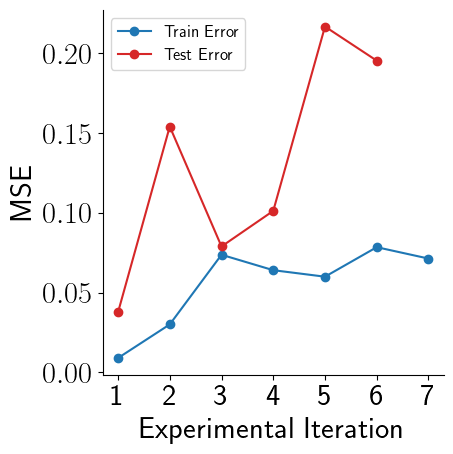

In [7]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    xticks = np.arange(1, TOTAL_ITERATIONS+1)
    ax.plot(xticks, accuracies[:,0],  "-o", color="tab:blue", label="Train Error")

    ax.plot(xticks, accuracies[:,1],  "-o", color="tab:red", label="Test Error")
    xlabels = ["%d"%x for x in xticks]

    ax.set_xticks(xticks, labels=xlabels)
    # ax.set_ylim([0.0, 0.2])
    ax.set_ylabel("MSE")
    ax.set_xlabel("Experimental Iteration")
    ax.legend(fontsize=12)    
    fig.tight_layout()
    plt.savefig("./figures/error.png") 
    plt.show()